# Develop a CasADi Model of The Steady-State Solar Plant RTO Problem

Replicates the calculations in the following Excel spreadsheet and uses CasADi to solve the optimization problem.

- `SS Solar Plant Optimization New Thermal & Flow Model 15 DVs I-O 2025-10-12a.xlsm`

In [15]:
import os
import casadi as cas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import functions from the solar_plant_rto module
from problems.solar_plant_rto.solar_plant_gen_rto import (
    PUMP_SPEED_MIN,
    PUMP_SPEED_MAX,
    actual_pump_speed_from_scaled,
    calculate_pump_and_drive_efficiency,
    calculate_pump_dp,
    calculate_pump_fluid_power,
    calculate_collector_flow_rate,
    calculate_collector_oil_exit_temp,
    solar_plant_rto_solve,
    solar_plant_gen_rto_solve
)

In [16]:
plot_dir = "plots"
os.makedirs(plot_dir, exist_ok=True)

## Test Data

In [17]:
from tests.test_solar_plant_gen_rto import test_data

# This data is from the Excel spreadsheet
test_data

{'n_lines': 15,
 'm_pumps': 3,
 'pump_speed_scaled': 0.739913018149835,
 'actual_pump_speed': 2238.040923,
 'pump_dp': 257.2307857,
 'boiler_dp': 255.1689754,
 'total_flow_rate': 84.98338307,
 'pump_fluid_power': 6.072317334,
 'valve_positions': array([1.        , 0.95599165, 0.92291088, 0.89433513, 0.86938607,
        0.84657486, 0.82612905, 0.80724668, 0.95631988, 0.92254233,
        0.89408902, 0.86938689, 0.84675991, 0.8262568 , 0.80712772]),
 'loop_dp': 2.061810328,
 'collector_flow_rates': array([6.22550162, 6.07013877, 5.92389415, 5.77480293, 5.62632717,
        5.47529072, 5.32759246, 5.18117042, 6.07145634, 5.92210943,
        5.77342278, 5.62633231, 5.4765747 , 5.3285508 , 5.18021847]),
 'pump_and_drive_efficiency': 0.338782267,
 'pump_and_drive_power': 17.92395274,
 'oil_return_temp': 273.5052133,
 'ambient_temp': 20,
 'solar_rate': 700,
 'loop_thermal_efficiencies': array([0.9 , 0.88, 0.86, 0.84, 0.82, 0.8 , 0.78, 0.76, 0.88, 0.86, 0.84,
        0.82, 0.8 , 0.78, 0.76]),
 '

In [18]:
m_pumps = test_data['m_pumps']
n_lines = test_data['n_lines']

## Pump Characteristics

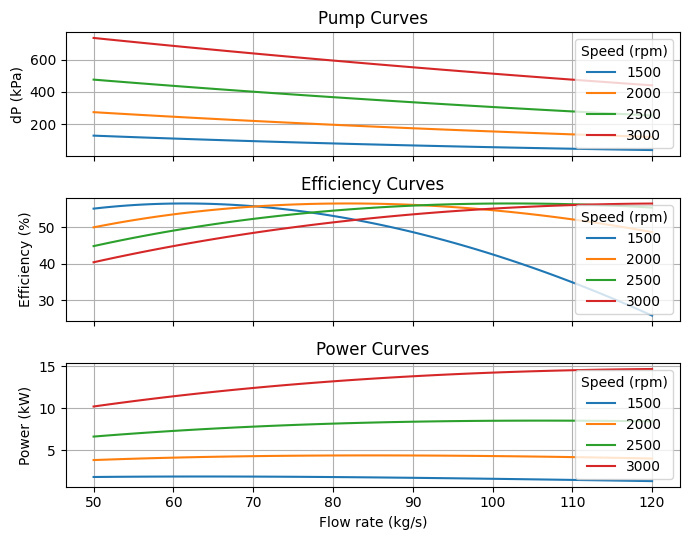

In [19]:
flow_rates = np.linspace(50, 120, 71)

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(7, 5.5))

for pump_speed in [1500, 2000, 2500, 3000]:
    efficiency = calculate_pump_and_drive_efficiency(
        flow_rates, pump_speed
    )
    delta_p = calculate_pump_dp(
        pump_speed, flow_rates, m_pumps
    )
    power = calculate_pump_fluid_power(flow_rates, delta_p)

    ax = axes[0]
    ax.plot(flow_rates, delta_p, label=pump_speed)
    ax.set_ylabel('dP (kPa)')
    ax.grid(True)
    ax.legend(title="Speed (rpm)")
    ax.set_title("Pump Curves")


    ax = axes[1]
    ax.plot(flow_rates, efficiency * 100, label=pump_speed)
    ax.set_ylabel('Efficiency (%)')
    ax.grid(True)
    ax.legend(title="Speed (rpm)")
    ax.set_title("Efficiency Curves")

    ax = axes[2]
    ax.plot(flow_rates, power, label=pump_speed)
    ax.set_xlabel('Flow rate (kg/s)')
    ax.set_ylabel('Power (kW)')
    ax.grid(True)
    ax.legend(title="Speed (rpm)")
    ax.set_title("Power Curves")

plt.tight_layout()
plt.show()

## Collector Line Flow Characteristics

In [20]:
test_data['oil_return_temp']

273.5052133

In [21]:
test_data['loop_dp']

2.061810328

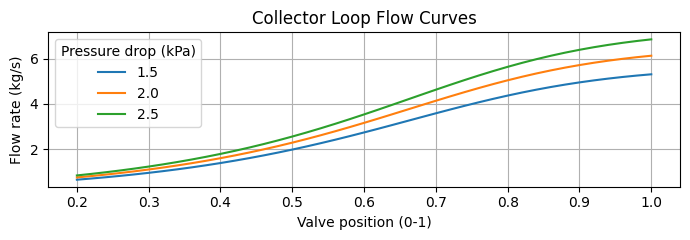

In [22]:
valve_positions = np.linspace(0.2, 1.0, 41)

fig, ax = plt.subplots(figsize=(7, 2.5))

for delta_p in [1.5, 2.0, 2.5]:
    flow_rates = calculate_collector_flow_rate(
        valve_positions, delta_p, sqrt=np.sqrt
    )

    ax.plot(valve_positions, flow_rates, label=delta_p)
    ax.set_xlabel('Valve position (0-1)')
    ax.set_ylabel('Flow rate (kg/s)')
    ax.grid(True)
    ax.legend(title="Pressure drop (kPa)")
    ax.set_title("Collector Loop Flow Curves")

plt.tight_layout()
plt.show()

## Oil Exit Temperature Calculations

In [23]:
test_data['oil_exit_temps'][0], test_data['collector_flow_rates'][0], test_data["loop_thermal_efficiencies"][0]

(np.float64(389.8923752), np.float64(6.225501621), np.float64(0.9))

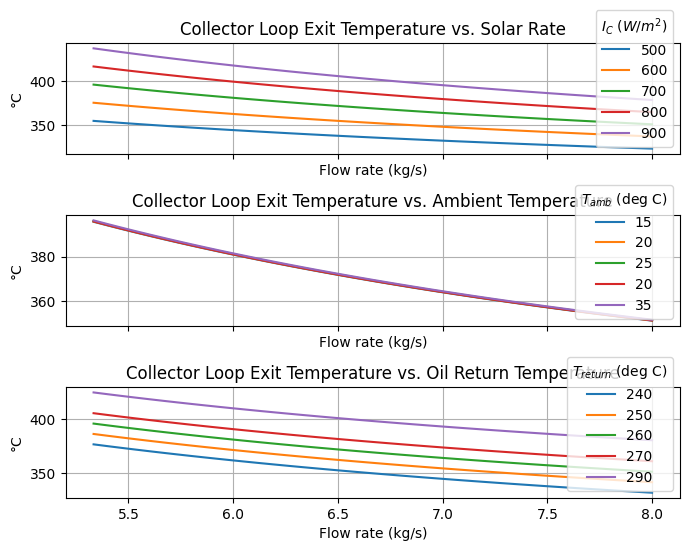

In [24]:
# X-axis: flow rate per line (kg/s)
flow_rates = np.linspace(80, 120, 41) / 15  # per line

# Plot curves
oil_return_temps = [240, 250, 260, 270, 290]  # degC
ambient_temps = [15, 20, 25, 20, 35]  # degC
solar_rates = [500, 600, 700, 800, 900]  # W/m2
loop_thermal_efficiency = 0.9

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(7, 5.5))

ax = axes[0]
for solar_rate in solar_rates:
    oil_exit_temps = calculate_collector_oil_exit_temp(
        flow_rates,
        oil_return_temps[2],
        ambient_temps[2],
        solar_rate,
        loop_thermal_efficiency,
        exp=np.exp,
        pi=np.pi
    )
    ax.plot(flow_rates, oil_exit_temps, label=solar_rate)
ax.set_ylabel('°C')
ax.grid(True)
ax.legend(title="$I_C$ ($W/m^2$)")
ax.set_title("Collector Loop Exit Temperature vs. Solar Rate")
ax.set_xlabel('Flow rate (kg/s)')

ax = axes[1]
for ambient_temp in ambient_temps:
    oil_exit_temps = calculate_collector_oil_exit_temp(
        flow_rates,
        oil_return_temps[2],
        ambient_temp,
        solar_rates[2],
        loop_thermal_efficiency,
        exp=np.exp,
        pi=np.pi
    )
    ax.plot(flow_rates, oil_exit_temps, label=ambient_temp)
ax.set_ylabel('°C')
ax.grid(True)
ax.legend(title="$T_{amb}$ (deg C)")
ax.set_title("Collector Loop Exit Temperature vs. Ambient Temperature")
ax.set_xlabel('Flow rate (kg/s)')


ax = axes[2]
for oil_return_temp in oil_return_temps:
    oil_exit_temps = calculate_collector_oil_exit_temp(
        flow_rates,
        oil_return_temp,
        ambient_temps[2],
        solar_rates[2],
        loop_thermal_efficiency,
        exp=np.exp,
        pi=np.pi
    )
    ax.plot(flow_rates, oil_exit_temps, label=oil_return_temp)
ax.set_ylabel('°C')
ax.grid(True)
ax.legend(title="$T_{return}$ (deg C)")
ax.set_title("Collector Loop Exit Temperature vs. Oil Return Temperature")
ax.set_xlabel('Flow rate (kg/s)')

plt.tight_layout()
plt.show()

## Solar Collector Lines and Pumps RTO Model

In [25]:
# Maximizes net potential energy generation

ambient_temp = 20  # degC
solar_rates = np.linspace(450, 900, 26)  # W/m2
oil_return_temp = 270  # degC

# Silence solver output
solver_opts = {'ipopt.tol': 1e-9, 'print_time': False, 'ipopt': {'print_level': 0}}

valve_positions = []
oil_flow_rates = []
oil_exit_temps = []
pump_speeds = []
potential_work = []
index_values = []

for solar_rate in tqdm(solar_rates):

    sol, variables = solar_plant_rto_solve(
        solar_rate,
        ambient_temp,
        oil_return_temp,
        m_pumps,
        n_lines,
        solver_opts=solver_opts
    )
    actual_pump_speed = actual_pump_speed_from_scaled(
        variables['pump_speed_scaled']
    )

    valve_positions.append(variables['valve_positions'])
    oil_flow_rates.append(variables['collector_flow_rates'])
    oil_exit_temps.append(variables['oil_exit_temps'])
    pump_speeds.append(actual_pump_speed)
    potential_work.append(variables['potential_work'])
    index_values.append(solar_rate)

valve_positions = pd.DataFrame.from_records(
    valve_positions,
    index=pd.Index(index_values, name='Solar Rate (W/m2)'),
    columns=pd.Index(range(n_lines), name='Collector Line')
)
oil_flow_rates = pd.DataFrame.from_records(
    oil_flow_rates,
    index=pd.Index(index_values, name='Solar Rate (W/m2)'),
    columns=pd.Index(range(n_lines), name='Collector Line')
)
oil_exit_temps = pd.DataFrame.from_records(
    oil_exit_temps,
    index=pd.Index(index_values, name='Solar Rate (W/m2)'),
    columns=pd.Index(range(n_lines), name='Collector Line')
)
pump_speeds = pd.Series(
    pump_speeds,
    index=pd.Index(index_values, name='Pump Speed (RPM)'),
    name='Pump Speed (scaled)'
)
potential_work = pd.Series(
    potential_work,
    index=pd.Index(index_values, name='Potential Useful Work Output (kW)'),
    name='Pump Speed (scaled)'
)


100%|██████████| 26/26 [00:02<00:00, 13.00it/s]


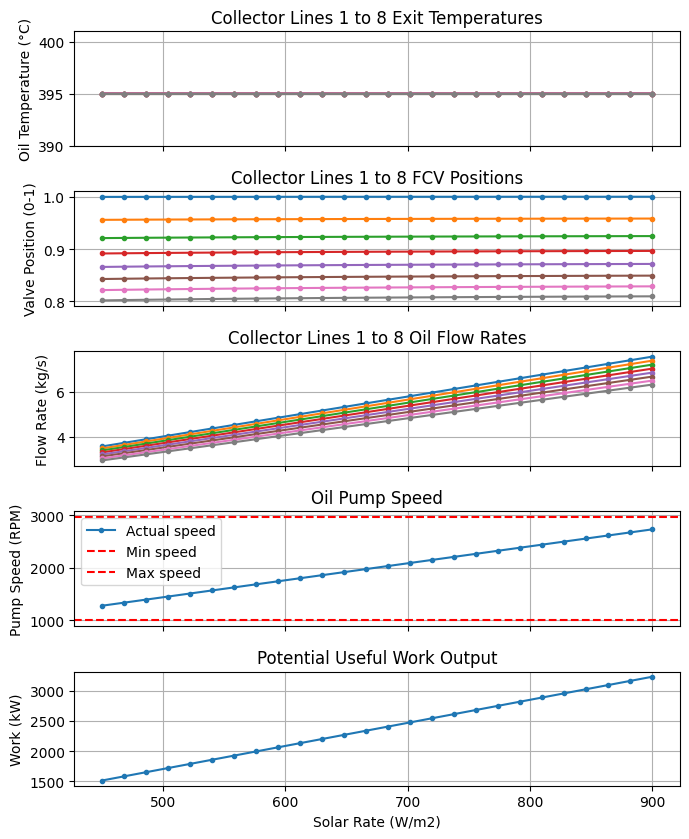

In [26]:
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(7, 8.5))

n_lines_to_plot = min(8, n_lines)

ax = axes[0]
for line in oil_exit_temps.columns[:n_lines_to_plot]:  # Plot first 8 lines only
    oil_exit_temps[line].plot(
        ax=ax,
        style='.-',
        title=f'Collector Lines 1 to {n_lines_to_plot} Exit Temperatures',
        xlabel='Solar Rate (W/m2)',
        ylabel='Oil Temperature (°C)',
    )
ax.set_ylim([390, 401])
ax.grid(True)

ax = axes[1]
for line in valve_positions.columns[:n_lines_to_plot]:  # Plot first 8 lines only
    valve_positions[line].plot(
        ax=ax,
        style='.-',
        title=f'Collector Lines 1 to {n_lines_to_plot} FCV Positions',
        xlabel='Solar Rate (W/m2)',
        ylabel='Valve Position (0-1)',
    )
ax.set_ylim([None, 1.01])
ax.grid(True)

ax = axes[2]
for line in oil_flow_rates.columns[:n_lines_to_plot]:  # Plot first 8 lines only
    oil_flow_rates[line].plot(
        ax=ax,
        style='.-',
        title=f'Collector Lines 1 to {n_lines_to_plot} Oil Flow Rates',
        xlabel='Solar Rate (W/m2)',
        ylabel='Flow Rate (kg/s)',
    )
ax.grid(True)

ax = axes[3]
pump_speeds.plot(
    ax=ax,
    style='.-',
    title=f'Oil Pump Speed',
    xlabel='Solar Rate (W/m2)',
    ylabel='Pump Speed (RPM)',
    label='Actual speed',
)
ax.axhline(PUMP_SPEED_MIN, color='red', linestyle='--', label='Min speed')
ax.axhline(PUMP_SPEED_MAX, color='red', linestyle='--', label='Max speed')
ax.grid(True)
ax.legend()

ax = axes[4]
potential_work.plot(
    ax=ax,
    style='.-',
    title=f'Potential Useful Work Output',
    xlabel='Solar Rate (W/m2)',
    ylabel='Work (kW)',
)
ax.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "solar_plant_rto_results.png"), dpi=150)
plt.show()

## Combined Solar Collector Lines, Pumps and Power Generator RTO Model

In [27]:
# Maximizes net power generation

ambient_temp = 20  # degC
solar_rates = [450.0, 500.0, 550.0, 600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0]  # W/m2

# Silence solver output
solver_opts = {'ipopt.tol': 1e-9, 'print_time': False, 'ipopt': {'print_level': 0}}

valve_positions = []
oil_flow_rates = []
oil_exit_temps = []
pump_speeds = []
net_power_output = []
index_values = []

for solar_rate in tqdm(solar_rates):

    sol, variables = solar_plant_gen_rto_solve(
        ambient_temp,
        solar_rate,
        n_lines,
        m_pumps,
        valve_positions_init=0.9,
        pump_speed_scaled_init=0.3,
        m_dot_init=0.75,
        oil_return_temp_init=260.0,
        solver_opts=solver_opts
    )
    actual_pump_speed = actual_pump_speed_from_scaled(
        variables['pump_speed_scaled']
    )

    valve_positions.append(variables['valve_positions'])
    oil_flow_rates.append(variables['collector_flow_rates'])
    oil_exit_temps.append(variables['oil_exit_temps'])
    pump_speeds.append(actual_pump_speed)
    net_power_output.append(variables['net_power'])
    index_values.append(solar_rate)

valve_positions = pd.DataFrame.from_records(
    valve_positions,
    index=pd.Index(index_values, name='Solar Rate (W/m2)'),
    columns=pd.Index(range(n_lines), name='Collector Line')
)
oil_flow_rates = pd.DataFrame.from_records(
    oil_flow_rates,
    index=pd.Index(index_values, name='Solar Rate (W/m2)'),
    columns=pd.Index(range(n_lines), name='Collector Line')
)
oil_exit_temps = pd.DataFrame.from_records(
    oil_exit_temps,
    index=pd.Index(index_values, name='Solar Rate (W/m2)'),
    columns=pd.Index(range(n_lines), name='Collector Line')
)
pump_speeds = pd.Series(
    pump_speeds,
    index=pd.Index(index_values, name='Solar Rate (W/m2)'),
    name='Pump Speed (RPM)'
)
net_power_output = pd.Series(
    net_power_output,
    index=pd.Index(index_values, name='Solar Rate (W/m2)'),
    name='Net Power Output (kW)'
)

100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


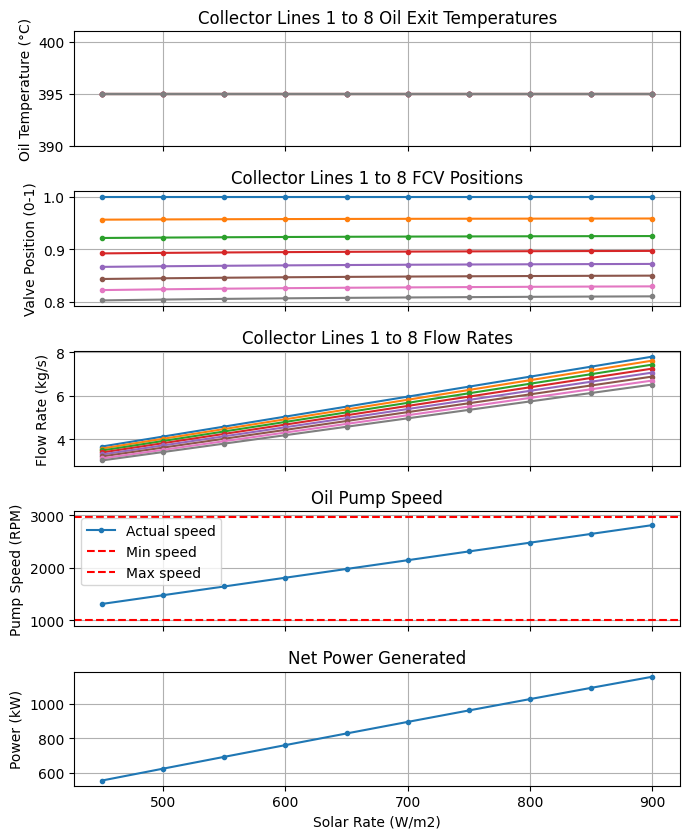

In [28]:
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(7, 8.5))

n_lines_to_plot = min(8, n_lines)

ax = axes[0]
for line in oil_exit_temps.columns[:n_lines_to_plot]:  # Plot first 8 lines only
    oil_exit_temps[line].plot(
        ax=ax,
        style='.-',
        title=f'Collector Lines 1 to {n_lines_to_plot} Oil Exit Temperatures',
        xlabel='Solar Rate (W/m2)',
        ylabel='Oil Temperature (°C)',
    )
ax.set_ylim([390, 401])
ax.grid(True)

ax = axes[1]
for line in valve_positions.columns[:n_lines_to_plot]:  # Plot first 8 lines only
    valve_positions[line].plot(
        ax=ax,
        style='.-',
        title=f'Collector Lines 1 to {n_lines_to_plot} FCV Positions',
        xlabel='Solar Rate (W/m2)',
        ylabel='Valve Position (0-1)',
    )
ax.set_ylim([None, 1.01])
ax.grid(True)

ax = axes[2]
for line in oil_flow_rates.columns[:n_lines_to_plot]:  # Plot first 8 lines only
    oil_flow_rates[line].plot(
        ax=ax,
        style='.-',
        title=f'Collector Lines 1 to {n_lines_to_plot} Flow Rates',
        xlabel='Solar Rate (W/m2)',
        ylabel='Flow Rate (kg/s)',
    )
ax.grid(True)

ax = axes[3]
pump_speeds.plot(
    ax=ax,
    style='.-',
    title=f'Oil Pump Speed',
    xlabel='Solar Rate (W/m2)',
    ylabel='Pump Speed (RPM)',
    label='Actual speed',
)
ax.axhline(PUMP_SPEED_MIN, color='red', linestyle='--', label='Min speed')
ax.axhline(PUMP_SPEED_MAX, color='red', linestyle='--', label='Max speed')
ax.grid(True)
ax.legend()

ax = axes[4]
net_power_output.plot(
    ax=ax,
    style='.-',
    title=f'Net Power Generated',
    xlabel='Solar Rate (W/m2)',
    ylabel='Power (kW)',
)
ax.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "solar_plant_rto_gen_results.png"), dpi=150)
plt.show()